<a href="https://colab.research.google.com/github/kim-kidong/hello-world/blob/master/0919_%E1%84%8C%E1%85%A5%E1%86%AB%E1%84%85%E1%85%A7%E1%86%A8%E1%84%83%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A5%E1%84%87%E1%85%AE%E1%86%AB%E1%84%89%E1%85%A5%E1%86%A8_GRU_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#from common.utils import load_data, mape

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [0]:
energy = pd.read_csv(os.path.join('data', 'energy_3years.csv'), parse_dates=['timestamp']) 
energy.head()


,timestamp,load,temp
0,2012-01-01 00:00:00,"2,698.00",32.00
1,2012-01-01 01:00:00,"2,558.00",32.67
2,2012-01-01 02:00:00,"2,444.00",30.00
3,2012-01-01 03:00:00,"2,402.00",31.00
4,2012-01-01 04:00:00,"2,403.00",32.00


In [0]:
energy.index = energy['timestamp']
energy = energy.reindex(pd.date_range(min(energy['timestamp']),
                max(energy['timestamp']), freq='H'))
energy = energy.drop('timestamp', axis=1)[['load']]
energy.head()

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


In [0]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

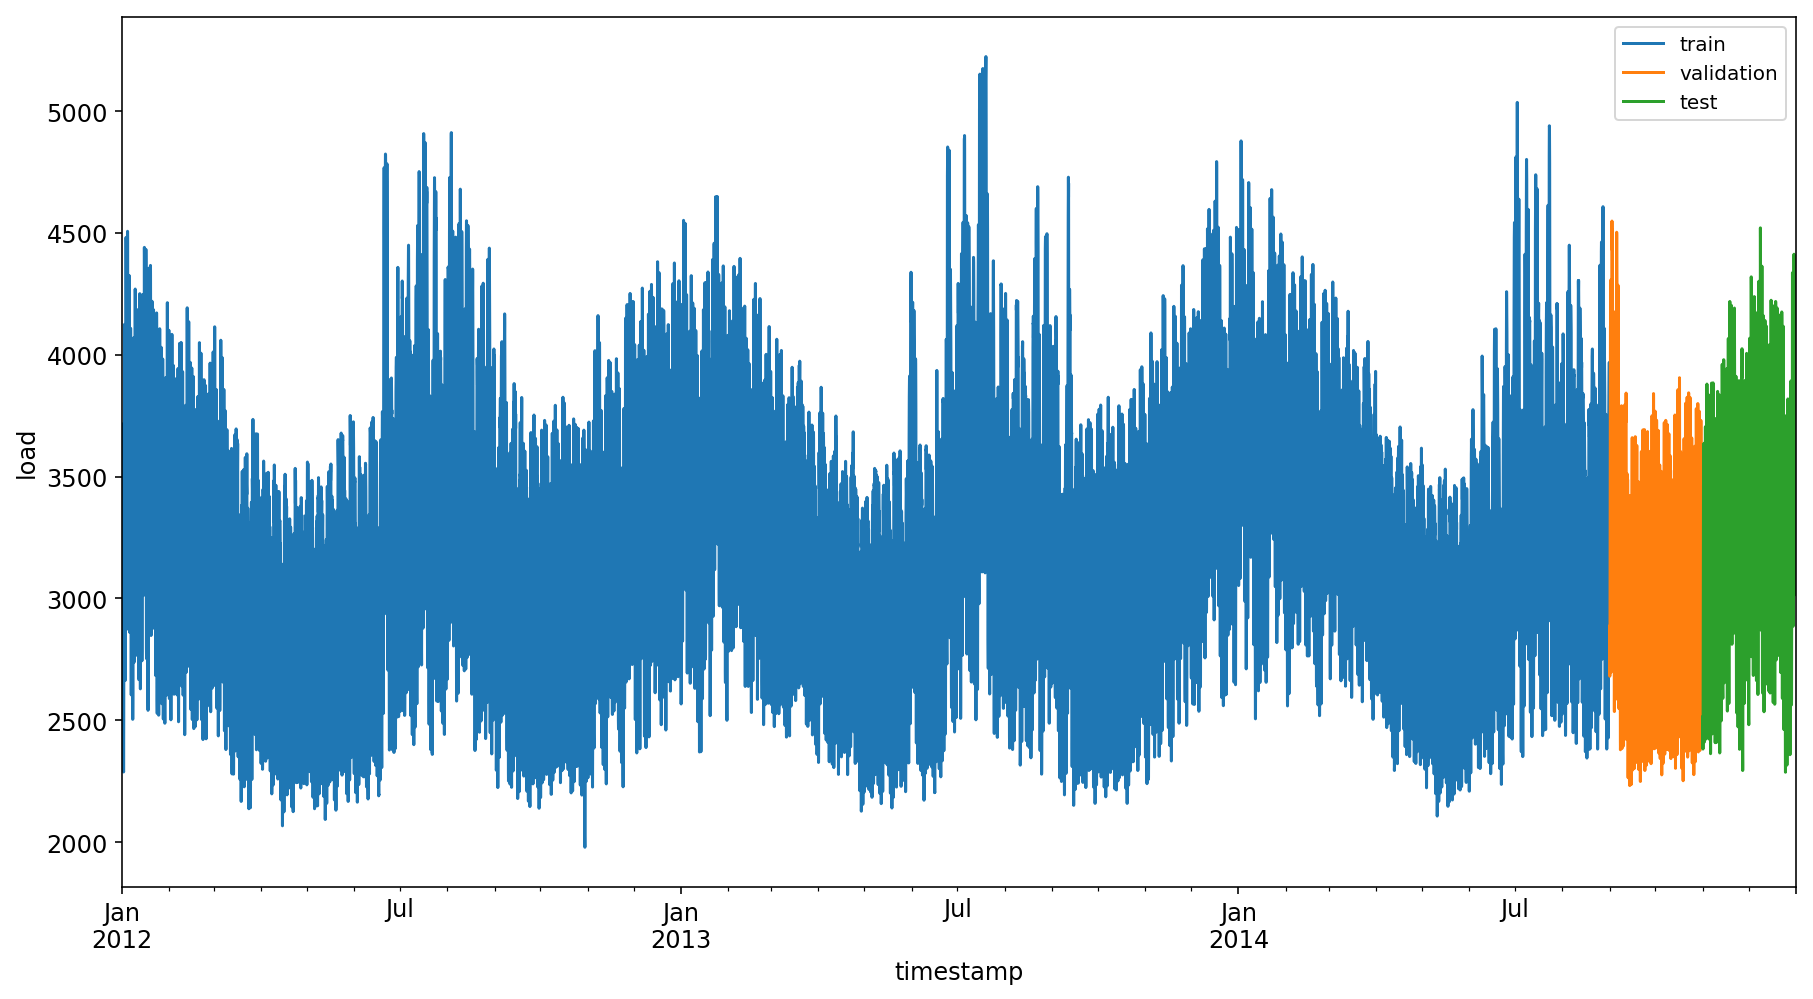

In [0]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'train'}) \
    .join(energy[(energy.index >=valid_start_dt) & (energy.index < test_start_dt)][['load']] \
          .rename(columns={'load':'validation'}), how='outer') \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [0]:
T = 6
HORIZON = 1

In [0]:
# 1. Get the train data from the correct data range
train = energy.copy()[energy.index < valid_start_dt][['load']]

# 2. Scale data to be in range (0, 1). 
#   This transformation should be calibrated on the training set only. 
#   This is to prevent information from the validation or test sets 
#   leaking into the training data.
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)

# 3. Shift the dataframe to create the input samples.
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted['load'].shift(T-t, freq='H')
y_col = 'y_t+1'
X_cols = ['load_t-5',
             'load_t-4',
             'load_t-3',
             'load_t-2',
             'load_t-1',
             'load_t']
train_shifted.columns = ['load_original']+[y_col]+X_cols

# 4.Discard any samples with missing values
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35


In [0]:
# 5.Transform this Pandas dataframe into a numpy array
y_train = train_shifted[y_col].as_matrix()
X_train = train_shifted[X_cols].as_matrix()

In [0]:
X_train.shape

(23370, 6)

In [0]:
y_train.shape

(23370,)

In [0]:
# This is an important step to reshape the X into 3 dimension array
X_train = X_train.reshape(X_train.shape[0], T, 1)

In [0]:
X_train.shape

(23370, 6, 1)

In [0]:
train_shifted.head(3)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23


In [0]:
# 1. Get the validation data from the correct data range
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]

# 2. Scale the series using the transformer fitted on the training set:
valid['load'] = scaler.transform(valid)

# 3. Shift the dataframe to create the input samples
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    valid_shifted['load_t-'+str(T-t)] = valid_shifted['load'].shift(T-t, freq='H')
    
# 4.Discard any samples with missing values
valid_shifted = valid_shifted.dropna(how='any')
valid_shifted.head(3)

,load,y+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
2014-09-01 00:00:00,0.28,0.24,0.61,0.58,0.51,0.43,0.34,0.28
2014-09-01 01:00:00,0.24,0.22,0.58,0.51,0.43,0.34,0.28,0.24
2014-09-01 02:00:00,0.22,0.22,0.51,0.43,0.34,0.28,0.24,0.22


In [0]:
# 5.Transform this Pandas dataframe into a numpy array
y_valid = valid_shifted['y+1'].as_matrix()
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].as_matrix()
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

In [0]:
X_valid.shape

(1463, 6, 1)

In [0]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [0]:
LATENT_DIM = 5 # number of units in the RNN layer
BATCH_SIZE = 32 # number of samples per mini-batch
EPOCHS = 10 # maximum number of times the training algorithm will cycle through all samples

In [0]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [0]:
model.compile(optimizer='RMSprop', loss='mse')

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 105       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


In [0]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [0]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

Train on 23370 samples, validate on 1463 samples
Epoch 1/10
23370/23370 [==============================] - 8s 328us/step - loss: 0.0029 - val_loss: 0.0011
Epoch 2/10
23370/23370 [==============================] - 4s 191us/step - loss: 8.8347e-04 - val_loss: 6.9677e-04
Epoch 3/10
23370/23370 [==============================] - 4s 180us/step - loss: 6.6031e-04 - val_loss: 6.9772e-04
Epoch 4/10
23370/23370 [==============================] - 4s 179us/step - loss: 5.9341e-04 - val_loss: 5.2293e-04
Epoch 5/10
23370/23370 [==============================] - 4s 184us/step - loss: 5.6884e-04 - val_loss: 5.7105e-04
Epoch 6/10
23370/23370 [==============================] - 4s 167us/step - loss: 5.5940e-04 - val_loss: 4.9445e-04
Epoch 7/10
23370/23370 [==============================] - 5s 199us/step - loss: 5.5455e-04 - val_loss: 6.3207e-04
Epoch 8/10
23370/23370 [==============================] - 5s 208us/step - loss: 5.5158e-04 - val_loss: 5.2386e-04
Epoch 9/10
23370/23370 [=======================

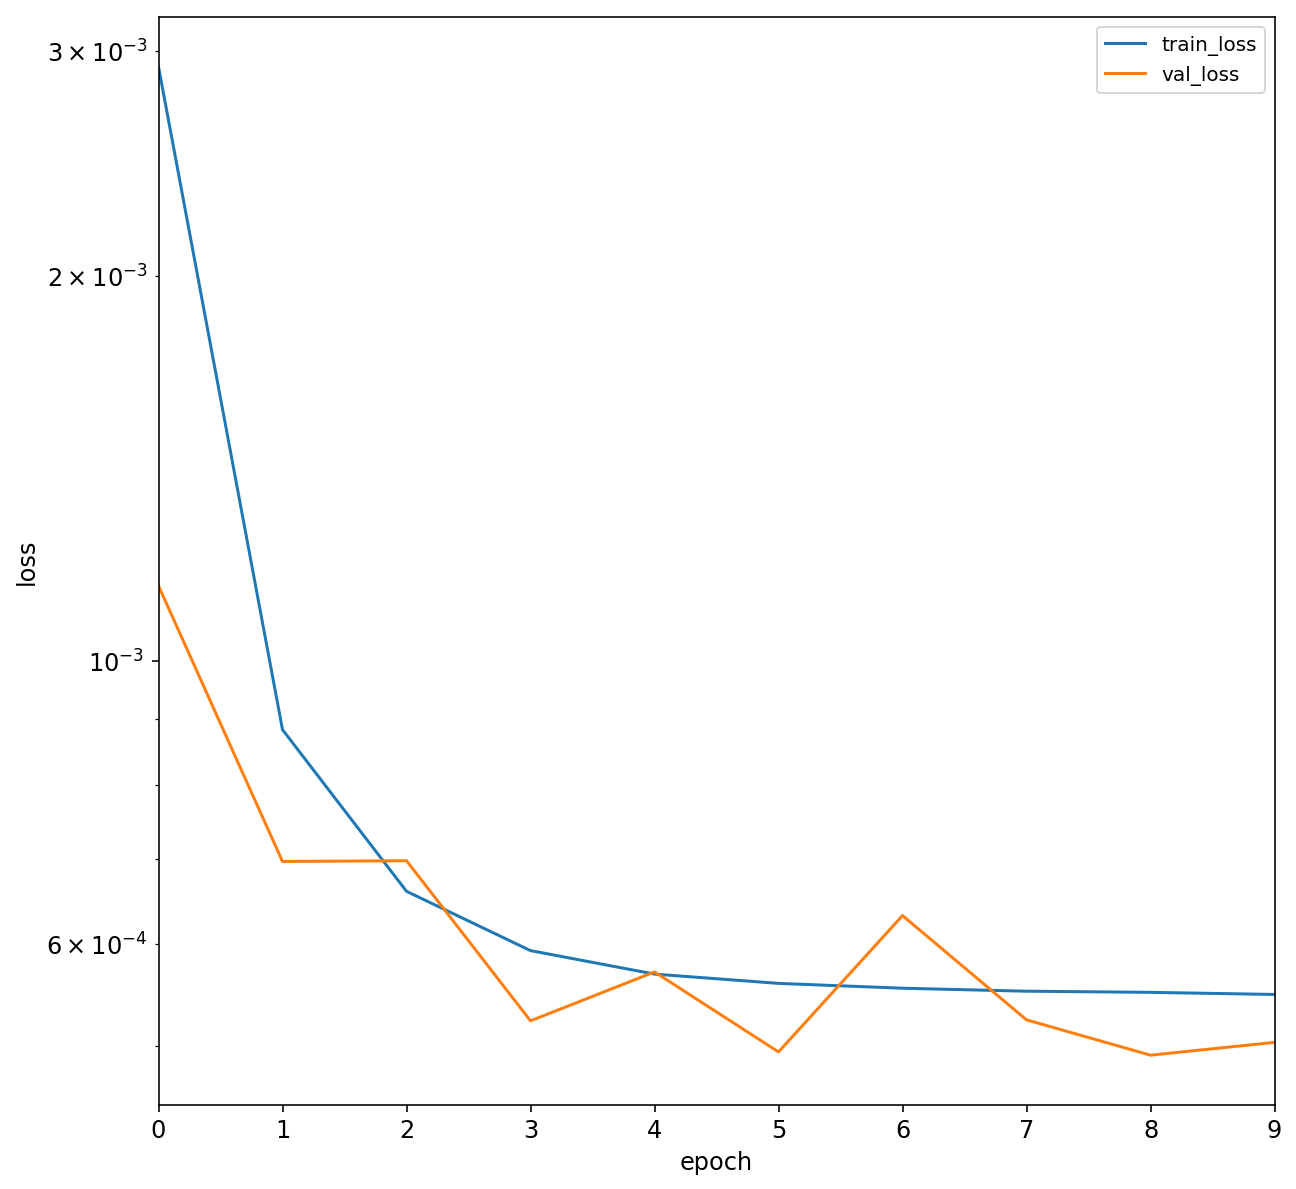

In [0]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [0]:
# 1. Get the test data from the correct data range
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load']]

# 2. Scale the data
test['load'] = scaler.transform(test)

# 3. Shift the dataframe to create the input samples
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    test_shifted['load_t-'+str(T-t)] = test_shifted['load'].shift(T-t, freq='H')

# 4.Discard any samples with missing values
test_shifted = test_shifted.dropna(how='any')

# 5.Transform this Pandas dataframe into a numpy array
y_test = test_shifted['y_t+1'].as_matrix()
X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].as_matrix()
X_test = X_test.reshape(X_test.shape[0], T, 1)


In [0]:
predictions = model.predict(X_test)
predictions

array([[0.22],
       [0.3 ],
       [0.38],
       ...,
       [0.54],
       [0.46],
       [0.43]], dtype=float32)

In [0]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,682.25","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,947.71","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,212.42","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,347.16","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,474.65","3,436.00"


In [0]:
# %load -s mape common/utils.py
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [0]:
mape(eval_df['prediction'], eval_df['actual'])

0.015660147603370898

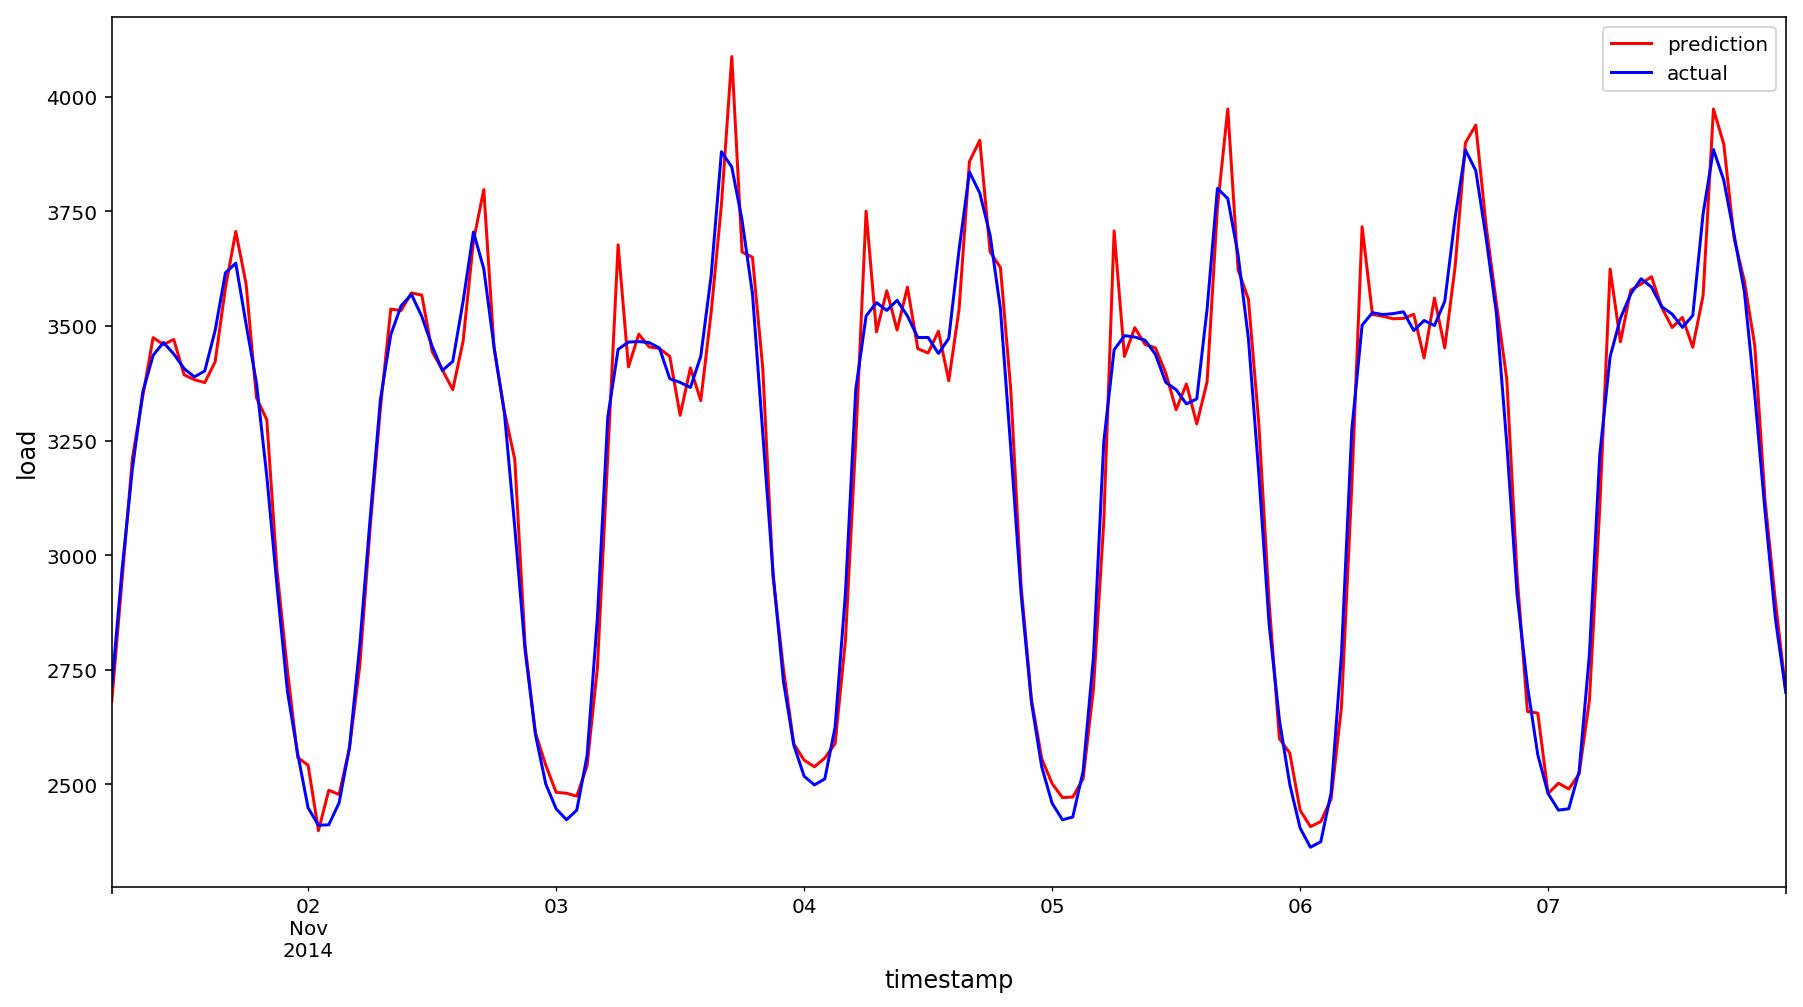

In [0]:
eval_df[eval_df.timestamp<'2014-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## GRU 개선해보기 실패

In [0]:
from keras.layers import Dropout

In [0]:
LATENT_DIM = 5 # number of units in the RNN layer
BATCH_SIZE = 32 # number of samples per mini-batch
EPOCHS = 100 # maximum number of times the training algorithm will cycle through all samples

In [0]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1),return_sequences=True))
model.add(Dropout(0.15))

model.add(GRU(LATENT_DIM, return_sequences=False))
model.add(Dropout(0.15))  # Dropout overfitting


#model.add(Dense(128, activation="relu"))
model.add(Dense(HORIZON))

In [0]:
model.compile(optimizer='adam', loss='mse')

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_18 (GRU)                 (None, 6, 5)              105       
_________________________________________________________________
dropout_10 (Dropout)         (None, 6, 5)              0         
_________________________________________________________________
gru_19 (GRU)                 (None, 5)                 165       
_________________________________________________________________
dropout_11 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6         
Total params: 276
Trainable params: 276
Non-trainable params: 0
_________________________________________________________________


In [0]:
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=5)

In [0]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

Train on 23370 samples, validate on 1463 samples
Epoch 1/100
23370/23370 [==============================] - 6s 258us/step - loss: 0.0180 - val_loss: 0.0039
Epoch 2/100
23370/23370 [==============================] - 4s 169us/step - loss: 0.0061 - val_loss: 0.0018
Epoch 3/100
23370/23370 [==============================] - 4s 164us/step - loss: 0.0037 - val_loss: 0.0013
Epoch 4/100
23370/23370 [==============================] - 4s 152us/step - loss: 0.0028 - val_loss: 0.0010
Epoch 5/100
23370/23370 [==============================] - 4s 168us/step - loss: 0.0025 - val_loss: 7.2337e-04
Epoch 6/100
23370/23370 [==============================] - 6s 260us/step - loss: 0.0024 - val_loss: 6.1660e-04
Epoch 7/100
23370/23370 [==============================] - 4s 172us/step - loss: 0.0023 - val_loss: 7.4042e-04
Epoch 8/100
23370/23370 [==============================] - 4s 180us/step - loss: 0.0022 - val_loss: 5.8066e-04
Epoch 9/100
23370/23370 [==============================] - 5s 195us/step - loss

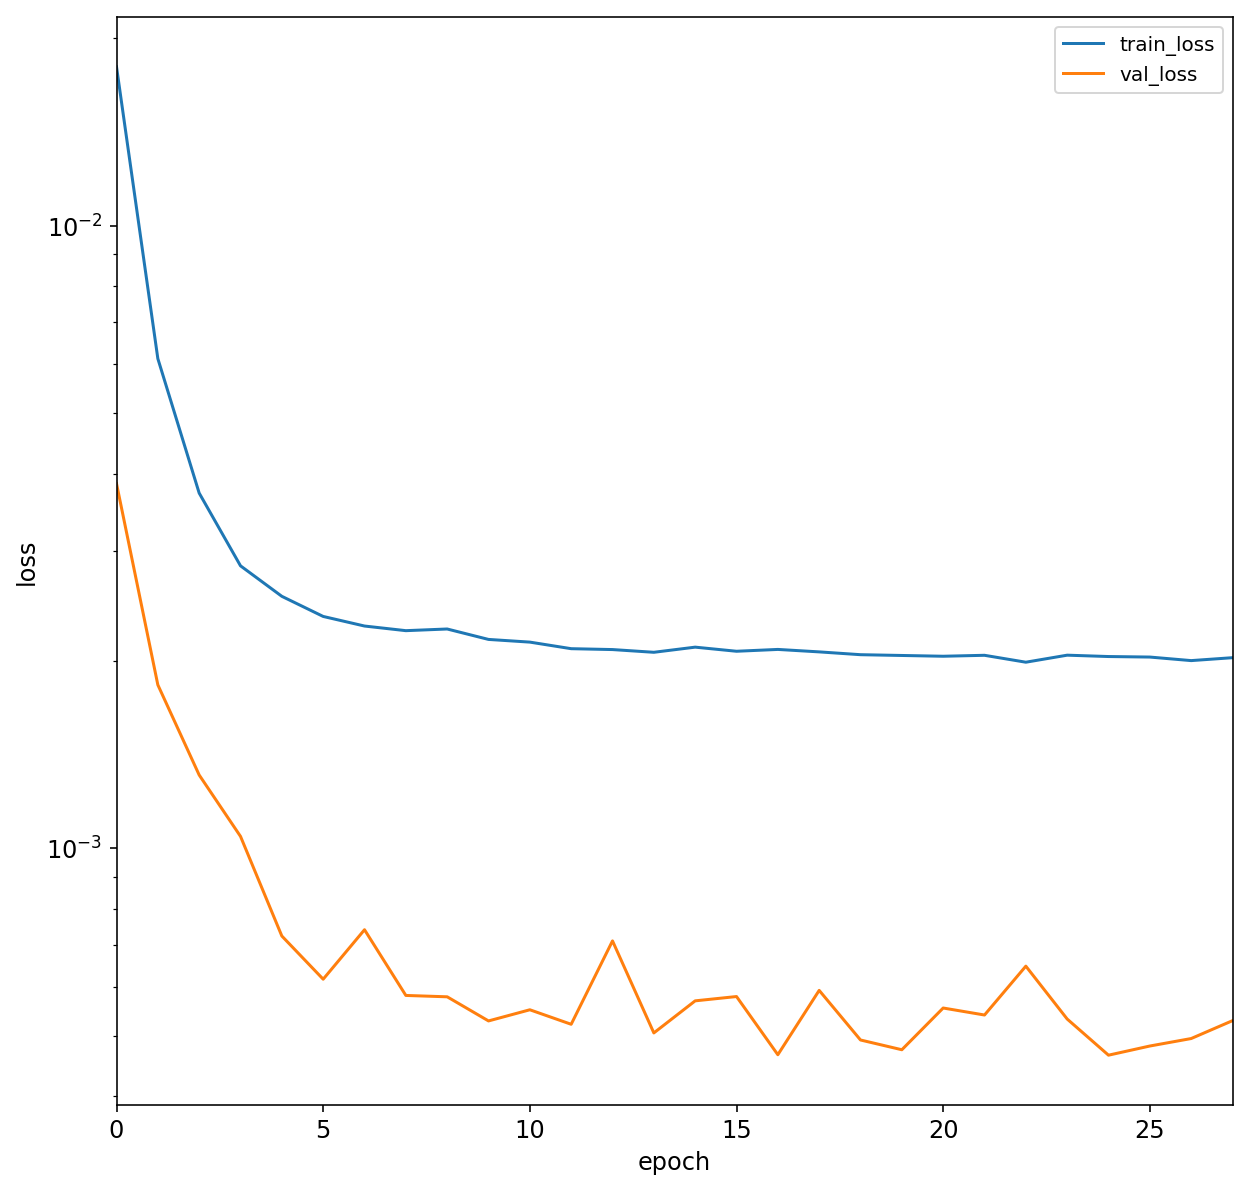

In [0]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [0]:
# 1. Get the test data from the correct data range
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load']]

# 2. Scale the data
test['load'] = scaler.transform(test)

# 3. Shift the dataframe to create the input samples
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    test_shifted['load_t-'+str(T-t)] = test_shifted['load'].shift(T-t, freq='H')

# 4.Discard any samples with missing values
test_shifted = test_shifted.dropna(how='any')

# 5.Transform this Pandas dataframe into a numpy array
y_test = test_shifted['y_t+1'].as_matrix()
X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].as_matrix()
X_test = X_test.reshape(X_test.shape[0], T, 1)


In [0]:
predictions = model.predict(X_test)
predictions

array([[0.23],
       [0.31],
       [0.38],
       ...,
       [0.54],
       [0.47],
       [0.43]], dtype=float32)

In [0]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,726.91","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,973.10","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,219.02","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,355.84","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,475.44","3,436.00"


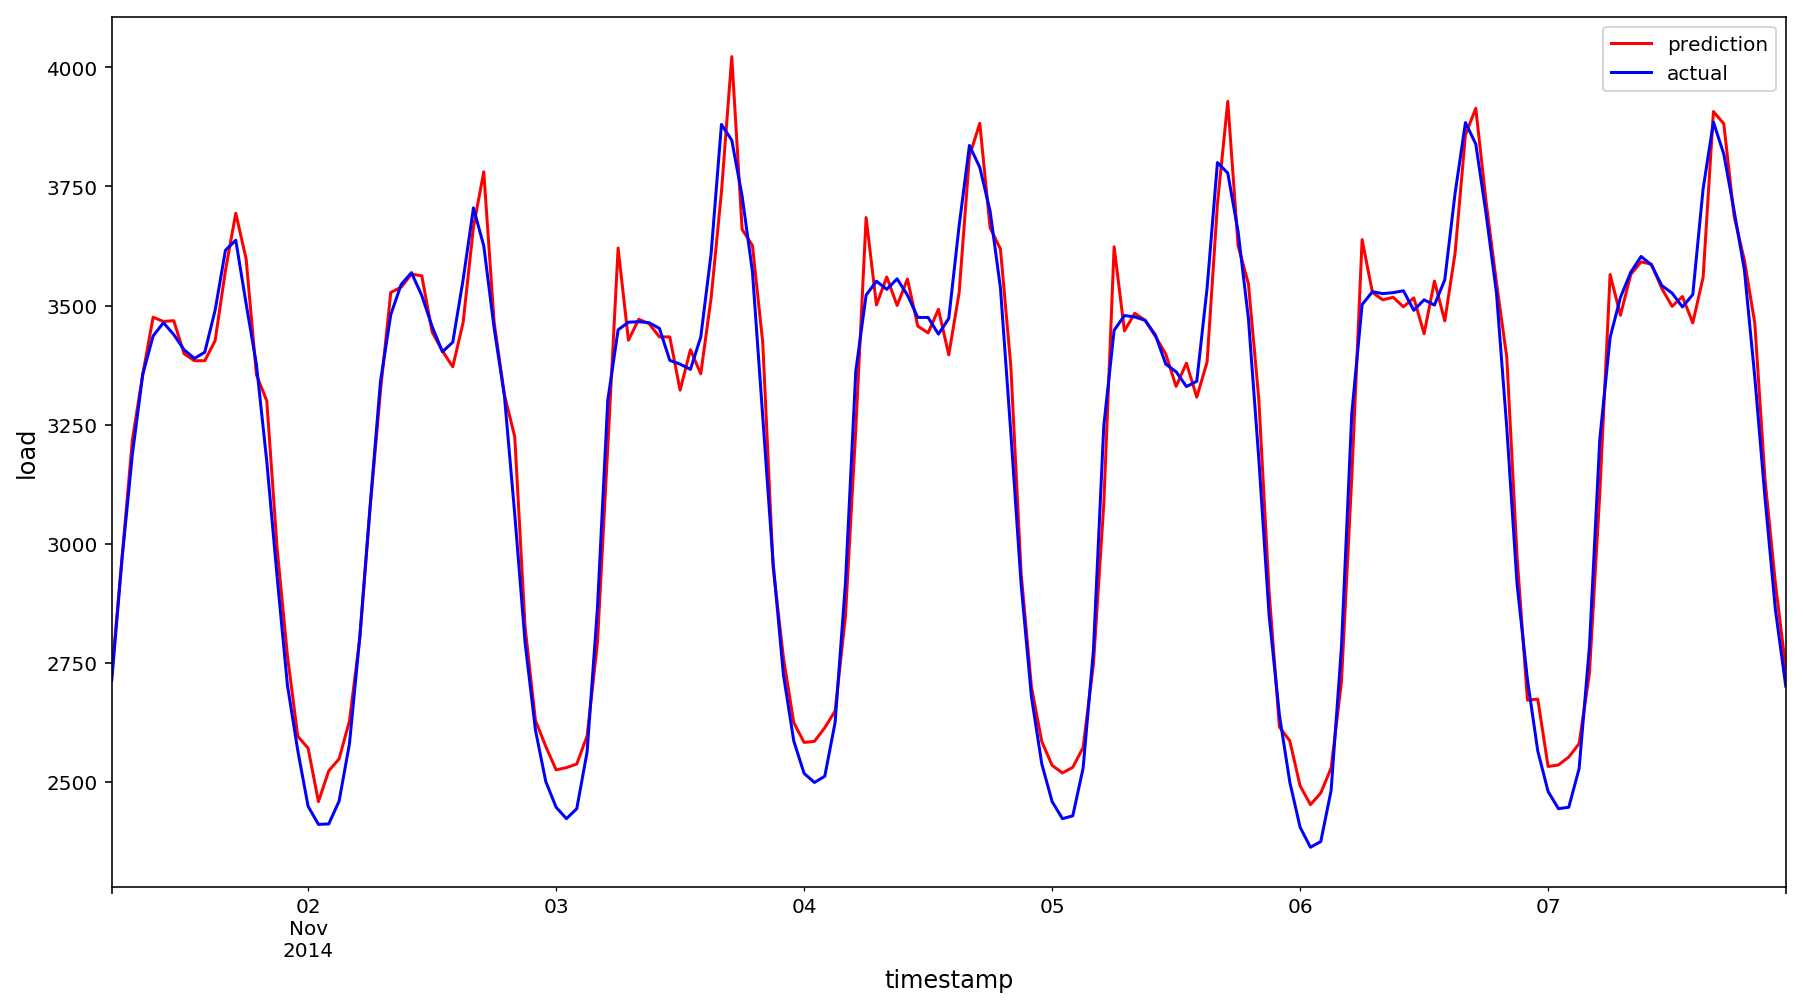

In [0]:
eval_df[eval_df.timestamp<'2014-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()